# Assignment #4: Deep Face Recognition Pipeline 

## 1. Face Detection

In [ ]:
import cv2
import os
import pandas as pd
from ultralytics import YOLO

# Input folder and CSV file
input_folder = '../CelebA-HQ-small/CelebA-HQ-small'
csv_path = '../CelebA-HQ-small/CelebA-HQ-small.csv'

# Load the YOLOv8 model (pre-trained)
model = YOLO('yolov8n-face.pt')  # YOLOv8 face detection model

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_path)

# Filter the dataset to only include the "test" set
test_df = df[df['split'] == 'test']

# Function to calculate Intersection-over-Union (IoU) between two bounding boxes
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    xi1, yi1 = max(x1, x2), max(y1, y2)
    xi2, yi2 = min(x1 + w1, x2 + w2), min(y1 + h1, y2 + h2)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area, box2_area = w1 * h1, w2 * h2
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area != 0 else 0

# Initialize a list to store IoU values
ious = []

# Process each image in the test set
for idx, row in test_df.iterrows():
    filename = f"{row['idx']}.jpg"
    image_path = os.path.join(input_folder, filename)

    # Log the current image being processed
    # print(f"Processing image {idx}: {filename}")

    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"[ERROR] Failed to load {filename}. Skipping.")
        continue

    # Run YOLO face detection
    results = model(image, verbose=False)
    detected_boxes = results[0].boxes.xywh.cpu().numpy()  # Detected bounding boxes (center x, y, width, height)

    # If at least one face is detected, calculate IoU and select the highest IoU
    if len(detected_boxes) > 0:
        max_iou = 0
        best_box = None
        ground_truth_box = (row['x_1'], row['y_1'], row['width'], row['height'])

        for box in detected_boxes:
            x, y, w, h = box
            detected_box = (int(x - w / 2), int(y - h / 2), int(w), int(h))  # Convert YOLO format to top-left format
            iou = calculate_iou(detected_box, ground_truth_box)

            # Track the box with the highest IoU
            if iou > max_iou:
                max_iou = iou
                best_box = detected_box

        ious.append(max_iou)
    else:
        print(f"[WARNING] No faces detected in {filename}. Skipping.")
        ious.append(0)  # IoU is 0 if no faces detected

# Calculate average IoU across the test set
average_iou = sum(ious) / len(ious) if ious else 0

# Print the results
print(f"\n[SUMMARY] Average IoU on Test Set: {average_iou:.4f}")

# Save the IoU results to a log file
with open('yolo_test_set_iou_results.txt', 'w') as log_file:
    log_file.write("[SUMMARY] IoU Results on Test Set using YOLO:\n")
    log_file.write(f"Average IoU: {average_iou:.4f}\n")
    log_file.write("IoU for each image:\n")
    for idx, iou in enumerate(ious):
        log_file.write(f"Image {test_df.iloc[idx]['idx']}: IoU = {iou:.4f}\n")

print("Test set IoU calculation completed and results saved.")

In [ ]:
import cv2
import os
import pandas as pd
from retinaface import RetinaFace

# Input folder and CSV file
input_folder = '../CelebA-HQ-small/CelebA-HQ-small'
csv_path = '../CelebA-HQ-small/CelebA-HQ-small.csv'

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_path)

# Filter the dataset to only include the "test" set
test_df = df[df['split'] == 'test']

# Function to calculate Intersection-over-Union (IoU) between two bounding boxes
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    xi1, yi1 = max(x1, x2), max(y1, y2)
    xi2, yi2 = min(x1 + w1, x2 + w2), min(y1 + h1, y2 + h2)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area, box2_area = w1 * h1, w2 * h2
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area != 0 else 0

# Initialize a list to store IoU values
ious = []

# Process each image in the test set
for idx, row in test_df.iterrows():
    filename = f"{row['idx']}.jpg"
    image_path = os.path.join(input_folder, filename)

    # Log the current image being processed
    # print(f"Processing image {idx + 1}/{len(test_df)}: {filename}")

    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"[ERROR] Failed to load {filename}. Skipping.")
        continue

    # Run RetinaFace face detection
    detections = RetinaFace.detect_faces(image)

    # Extract detected bounding boxes
    detected_boxes = []
    if isinstance(detections, dict):  # Check if any faces are detected
        for face_key, face_info in detections.items():
            box = face_info["facial_area"]  # Get bounding box
            x1, y1, x2, y2 = box
            detected_boxes.append((int(x1), int(y1), int(x2 - x1), int(y2 - y1)))

    # If exactly one face is detected, calculate IoU
    if len(detected_boxes) == 1:
        detected_box = detected_boxes[0]
        ground_truth_box = (row['x_1'], row['y_1'], row['width'], row['height'])
        iou = calculate_iou(detected_box, ground_truth_box)
        ious.append(iou)
    else:
        ious.append(0)  # IoU is 0 if no or multiple faces detected

# Calculate average IoU across the test set
average_iou = sum(ious) / len(ious) if ious else 0

# Print the results
print(f"\n[SUMMARY] Average IoU on Test Set: {average_iou:.4f}")

# Save the IoU results to a log file
with open('retinaface_test_set_iou_results.txt', 'w') as log_file:
    log_file.write("[SUMMARY] IoU Results on Test Set using RetinaFace:\n")
    log_file.write(f"Average IoU: {average_iou:.4f}\n")
    log_file.write("IoU for each image:\n")
    for idx, iou in enumerate(ious):
        log_file.write(f"Image {test_df.iloc[idx]['idx']}: IoU = {iou:.4f}\n")

print("Test set IoU calculation completed and results saved.")


In [15]:
import insightface
import pandas as pd
import cv2
import os

# Input folder and CSV file
input_folder = '/Users/anapoklukar/Desktop/bm/CelebA-HQ-small/CelebA-HQ-small'
csv_path = '/Users/anapoklukar/Desktop/bm/CelebA-HQ-small/CelebA-HQ-small.csv'

# Initialize InsightFace FaceAnalysis
model = insightface.app.FaceAnalysis(name='buffalo_l')  # Pretrained model
model.prepare(ctx_id=0, det_thresh=0.1)  # Use GPU (ctx_id=0); change to -1 for CPU

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_path)

# Filter the dataset to only include the "test" set
test_df = df[df['split'] == 'test']

# Function to calculate Intersection-over-Union (IoU) between two bounding boxes
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    xi1, yi1 = max(x1, x2), max(y1, y2)
    xi2, yi2 = min(x1 + w1, x2 + w2), min(y1 + h1, y2 + h2)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area, box2_area = w1 * h1, w2 * h2
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area != 0 else 0

# Initialize a list to store IoU values
ious = []

# Process each image in the test set
for idx, row in test_df.iterrows():
    filename = f"{row['idx']}.jpg"
    image_path = os.path.join(input_folder, filename)

    # Log the current image being processed
    # print(f"Processing image {idx + 1}/{len(test_df)}: {filename}")

    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"[ERROR] Failed to load {filename}. Skipping.")
        continue

    # Run InsightFace face detection
    results = model.get(image)
    detected_boxes = [face.bbox for face in results]  # Bounding boxes from InsightFace

    # Calculate IoU for all detected faces and take the highest
    if detected_boxes:
        ground_truth_box = (row['x_1'], row['y_1'], row['width'], row['height'])
        max_iou = 0
        for bbox in detected_boxes:
            x1, y1, x2, y2 = bbox
            detected_box = (int(x1), int(y1), int(x2 - x1), int(y2 - y1))  # Convert to (x, y, width, height) format
            iou = calculate_iou(detected_box, ground_truth_box)
            max_iou = max(max_iou, iou)
        ious.append(max_iou)
    else:
        ious.append(0)  # IoU is 0 if no faces are detected

# Calculate average IoU across the test set
average_iou = sum(ious) / len(ious) if ious else 0

# Print the results
print(f"\n[SUMMARY] Average IoU on Test Set: {average_iou:.4f}")

# Save the IoU results to a log file
with open('insightface_test_set_iou_results.txt', 'w') as log_file:
    log_file.write("[SUMMARY] IoU Results on Test Set using InsightFace:\n")
    log_file.write(f"Average IoU: {average_iou:.4f}\n")
    log_file.write("IoU for each image:\n")
    for idx, iou in enumerate(ious):
        log_file.write(f"Image {test_df.iloc[idx]['idx']}: IoU = {iou:.4f}\n")

print("Test set IoU calculation completed and results saved.")


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/anapoklukar/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/anapoklukar/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/anapoklukar/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/anapoklukar/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/anapoklukar/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4



[SUMMARY] Average IoU on Test Set: 0.8597
Test set IoU calculation completed and results saved.


## 2. Feature Extraction

In [3]:
from facenet_pytorch import InceptionResnetV1
import cv2
import pandas as pd
import os
import numpy as np
import torch

# Load the FaceNet model using facenet-pytorch
def load_facenet_model():
    """Load the pre-trained FaceNet model using facenet-pytorch."""
    # Initialize the InceptionResnetV1 model for face recognition (embedding extraction)
    resnet = InceptionResnetV1(pretrained='vggface2', classify=False).eval()

    return resnet

# Get the embeddings for an image
def get_facenet_embedding(image_path, resnet):
    """Get face embedding from an image using FaceNet."""
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image {image_path}")
        return None

    # Convert image to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize to the expected input size for FaceNet (160x160)
    img_rgb = cv2.resize(img_rgb, (160, 160))

    # Normalize image to the range [0, 1]
    img_rgb = img_rgb / 255.0

    # Convert image to tensor and add batch dimension
    img_tensor = torch.tensor(img_rgb).float().unsqueeze(0)
    img_tensor = img_tensor.permute(0, 3, 1, 2)  # Convert from HWC to CHW format

    # Get embedding from FaceNet
    embedding = resnet(img_tensor)

    # Return the embedding as a flattened numpy array
    return embedding.detach().cpu().numpy().flatten()

# Load the CSV file into a DataFrame
csv_path = '/Users/anapoklukar/Desktop/bm/CelebA-HQ-small/CelebA-HQ-small.csv'  # Path to the CSV file containing the metadata
df = pd.read_csv(csv_path)

# Filter only the "test" set from the CSV
test_df = df[df['split'] == 'test']  # Select rows where the 'split' column is marked as 'test'

# Initialize a dictionary to store FaceNet embeddings
test_faces_embeddings_facenet = {}

# Load the FaceNet model
resnet = load_facenet_model()

# Iterate through each image in the test set
faces_dir = "/Users/anapoklukar/Desktop/bm/CelebA-HQ-small/CelebA-HQ-small"  # Directory where the images are stored
for _, row in test_df.iterrows():  # Loop through each row in the test set DataFrame
    filename = f"{row['idx']}.jpg"  # Get the filename from the 'idx' column
    image_path = os.path.join(faces_dir, filename)  # Construct the full path to the image
    label = row['identity']  # Get the identity label

    # Get the embedding for the image using FaceNet
    embedding_facenet = get_facenet_embedding(image_path, resnet)
    if embedding_facenet is not None:
        test_faces_embeddings_facenet[row['idx']] = {'label': label, 'features': embedding_facenet.tolist()}  # Store FaceNet embedding

# At this point, you have the dictionary:
# test_faces_embeddings_facenet: contains FaceNet embeddings

  0%|          | 0.00/107M [00:00<?, ?B/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/facenet_pytorch/models/inception_resnet_v1.py:329: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature

In [17]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern, hog
from sklearn.preprocessing import StandardScaler

# 1. Local Binary Patterns (LBP)
def extract_lbp_features(image, radius=1, n_points=8):
    """
    Extract Local Binary Patterns (LBP) features from the input image.
    
    Parameters:
        image (numpy.ndarray): The input image (BGR).
        radius (int): The radius of the circular neighborhood.
        n_points (int): The number of sampling points in the circular neighborhood.
    
    Returns:
        lbp_hist (numpy.ndarray): The normalized histogram of LBP features.
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply LBP to the grayscale image
    lbp = local_binary_pattern(gray, n_points * radius, radius, method='uniform')
    
    # Get the number of bins for the histogram (based on the maximum LBP value)
    n_bins = int(lbp.max() + 1)
    
    # Compute the LBP histogram
    lbp_hist, _ = np.histogram(lbp, bins=n_bins, range=(0, n_bins))
    
    # Normalize the histogram to ensure the sum equals 1 (for better comparison across images)
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-7)  # Small constant to avoid division by zero
    
    return lbp_hist

# 2. Histogram of Oriented Gradients (HOG)
def extract_hog_features(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    """
    Extract Histogram of Oriented Gradients (HOG) features from the input image.
    
    Parameters:
        image (numpy.ndarray): The input image (BGR).
        pixels_per_cell (tuple): The size of each cell (height, width).
        cells_per_block (tuple): The number of cells per block (height, width).
    
    Returns:
        features (numpy.ndarray): The HOG feature vector.
    """
    # Convert the image to grayscale if it has more than one channel (BGR image)
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Extract HOG features from the image
    features = hog(
        image,  # Input grayscale image
        orientations=9,  # Number of gradient bins
        pixels_per_cell=pixels_per_cell,  # Size of each cell
        cells_per_block=cells_per_block,  # Number of cells per block
        block_norm='L2-Hys',  # Block normalization type
        visualize=False  # Don't visualize the HOG image (just return features)
    )
    
    return features

# 3. Dense SIFT
def extract_dense_sift_features(image, step_size=8):
    """
    Extract Dense Scale-Invariant Feature Transform (SIFT) features from the input image.
    
    Parameters:
        image (numpy.ndarray): The input image (BGR).
        step_size (int): The distance between keypoints in the dense grid (higher = sparser keypoints).
    
    Returns:
        descriptors_flat (numpy.ndarray): The flattened array of SIFT descriptors.
    """
    # Convert the image to grayscale (SIFT works on single-channel images)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Create a SIFT detector object
    sift = cv2.SIFT_create()
    
    # Create a dense grid of keypoints, with a step size determining the grid spacing
    keypoints = [
        cv2.KeyPoint(x, y, step_size)  # Generate keypoints at each grid position
        for y in range(0, gray.shape[0], step_size)  # Loop through image rows with step size
        for x in range(0, gray.shape[1], step_size)  # Loop through image columns with step size
    ]
    
    # Compute SIFT descriptors for the keypoints
    keypoints, descriptors = sift.compute(gray, keypoints)
    
    # If no descriptors are found (i.e., descriptors is None), return an empty array
    if descriptors is None:
        return np.array([])  # Handle cases where no keypoints are found
    
    # Flatten the list of descriptors to create a single feature vector
    return descriptors.flatten()

In [8]:
import cv2
import pandas as pd
import os

# Set paths
input_folder = '/Users/anapoklukar/Desktop/bm/CelebA-HQ-small/CelebA-HQ-small'
csv_path = '/Users/anapoklukar/Desktop/bm/CelebA-HQ-small/CelebA-HQ-small.csv'  # Path to the CSV file containing the metadata

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_path)  # Read the CSV that contains image metadata (e.g., 'idx', 'identity', etc.)

# Filter only the "test" set from the CSV
test_df = df[df['split'] == 'test']  # Select rows where the 'split' column is marked as 'test'

# Initialize dictionaries for storing extracted features from each image
lbp_features = {}  # Dictionary to store LBP features for each image
sift_features = {}  # Dictionary to store Dense SIFT features for each image
hog_features = {}  # Dictionary to store HOG features for each image

# Iterate through each image in the test set
for _, row in test_df.iterrows():  # Loop through each row in the filtered test set DataFrame
    filename = f"{row['idx']}.jpg"  # Construct the image filename using the 'idx' column
    label = row['identity']  # Get the label (identity) for the image
    image_path = os.path.join(input_folder, filename)  # Construct the full path to the image

    # Read the image from the disk
    image = cv2.imread(image_path)  # Open the image using OpenCV
    
    # Skip the image if it fails to load (e.g., if the file is missing or corrupted)
    if image is None:
        print(f"[ERROR] Failed to load {filename}. Skipping.")  # Print an error message
        continue  # Skip this iteration and move to the next image
    
    if row["idx"] in lbp_features:
        print(f"Skipping image {row['idx']} as features already extracted.")

    # Extract features using previously defined functions
    lbp_feat = extract_lbp_features(image)  # Extract LBP features (assumes this function is defined elsewhere)
    sift_feat = extract_dense_sift_features(image)  # Extract Dense SIFT features (assumes this function is defined elsewhere)
    hog_feat = extract_hog_features(image)  # Extract HOG features (assumes this function is defined elsewhere)

    # Save the extracted features along with their labels into the dictionaries
    lbp_features[row['idx']] = {'label': label, 'features': lbp_feat.tolist()}  # Store LBP features for this image
    sift_features[row['idx']] = {'label': label, 'features': sift_feat.tolist()}  # Store SIFT features for this image
    hog_features[row['idx']] = {'label': label, 'features': hog_feat.tolist()}  # Store HOG features for this image

Skipping image 1205 as features already extracted.
Skipping image 5389 as features already extracted.
Skipping image 6622 as features already extracted.
Skipping image 7311 as features already extracted.
Skipping image 10666 as features already extracted.
Skipping image 13261 as features already extracted.
Skipping image 18530 as features already extracted.
Skipping image 19817 as features already extracted.
Skipping image 19932 as features already extracted.
Skipping image 21727 as features already extracted.
Skipping image 24919 as features already extracted.
Skipping image 25532 as features already extracted.
Skipping image 25532 as features already extracted.
Skipping image 25532 as features already extracted.
Skipping image 28343 as features already extracted.
Skipping image 28733 as features already extracted.
Skipping image 28733 as features already extracted.


DeepFace - Rank-1 Accuracy: 85.57%
DeepFace - Rank-5 Accuracy: 90.63%
FaceNet - Rank-1 Accuracy: 96.96%
FaceNet - Rank-5 Accuracy: 99.75%
LBP - Rank-1 Accuracy: 4.05%
LBP - Rank-5 Accuracy: 21.01%
SIFT - Rank-1 Accuracy: 26.58%
SIFT - Rank-5 Accuracy: 50.38%
HOG - Rank-1 Accuracy: 15.19%
HOG - Rank-5 Accuracy: 38.73%


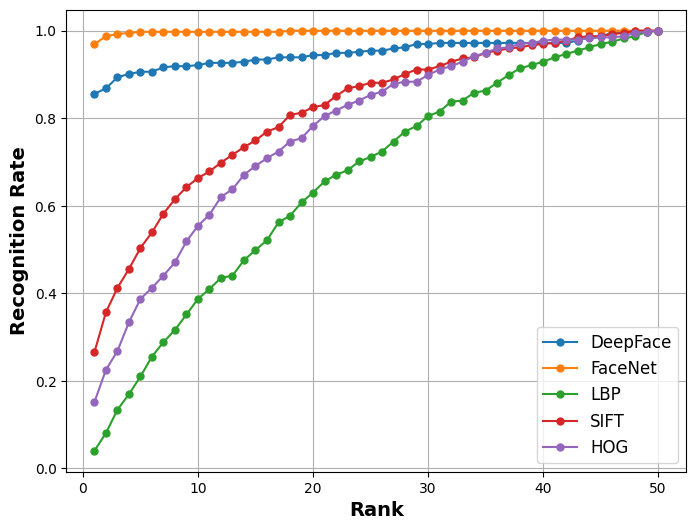

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def parse_features(data):
    """Extract features and labels from the given data dictionary."""
    features = []
    labels = []
    for idx, info in data.items():
        features.append(info['features'])
        labels.append(info['label'])
    return np.array(features), np.array(labels)

def calculate_similarity_matrix(features):
    """Calculate the cosine similarity matrix."""
    # Normalize features
    normalized_features = features / np.linalg.norm(features, axis=1, keepdims=True)
    # Compute pairwise cosine similarity
    similarity_matrix = np.dot(normalized_features, normalized_features.T)
    return similarity_matrix

def create_n_by_c_matrix(similarity_matrix, labels):
    """Transform similarity matrix to n x c matrix."""
    n = similarity_matrix.shape[0]
    unique_classes = np.unique(labels)
    c = len(unique_classes)
    
    # Map identities to column indices
    class_to_indices = {cls: np.where(labels == cls)[0] for cls in unique_classes}
    n_by_c_matrix = np.full((n, c), np.inf)
    
    # Fill the matrix with minimum dissimilarity values (1 - similarity)
    for i in range(n):
        for j, cls in enumerate(unique_classes):
            class_indices = class_to_indices[cls]
            valid_indices = [idx for idx in class_indices if idx != i]
            if valid_indices:
                n_by_c_matrix[i, j] = 1 - np.max(similarity_matrix[i, valid_indices])
    
    return n_by_c_matrix, unique_classes

def compute_ranks_and_cmc(n_by_c_matrix, true_labels, unique_classes):
    """Compute ranks and CMC for the dataset."""
    n, c = n_by_c_matrix.shape
    class_to_index = {cls: idx for idx, cls in enumerate(unique_classes)}
    ranks = np.zeros(n)
    
    for i in range(n):
        sorted_indices = np.argsort(n_by_c_matrix[i])  # Sort classes by similarity (ascending)
        sorted_classes = unique_classes[sorted_indices]
        true_class_index = class_to_index[true_labels[i]]
        ranks[i] = np.where(sorted_classes == true_labels[i])[0][0]  # Rank of the correct class

    cmc = np.zeros(c)
    for z in range(c):
        cmc[z] = np.sum(ranks <= z) / n  # Fraction of queries with rank <= z
    
    return ranks, cmc

def plot_cmc_curve(cmc_dict):
    """Plot the CMC curves for multiple feature types."""
    plt.figure(figsize=(8, 6))
    for feature_type, cmc in cmc_dict.items():
        plt.plot(np.arange(1, len(cmc) + 1), cmc, marker='o', label=feature_type, markersize=5, linewidth=1.5)
    plt.xlabel('Rank', fontsize=14, fontweight='bold')
    plt.ylabel('Recognition Rate', fontsize=14, fontweight='bold')
    plt.grid(True)
    plt.legend(loc='lower right', fontsize=12)
    plt.savefig("fullimagecmc.pdf", format='pdf')
    plt.show()

# Process each dataset and compute CMC
datasets = {"DeepFace": test_faces_embeddings_deepface, "FaceNet": test_faces_embeddings_facenet, "LBP": lbp_features, "SIFT": sift_features, "HOG": hog_features}
cmc_results = {}

for feature_type, data in datasets.items():
    features, labels = parse_features(data)
    similarity_matrix = calculate_similarity_matrix(features)
    n_by_c_matrix, unique_classes = create_n_by_c_matrix(similarity_matrix, labels)
    ranks, cmc = compute_ranks_and_cmc(n_by_c_matrix, labels, unique_classes)
    
    # Store CMC curve for plotting
    cmc_results[feature_type] = cmc

    # Print Rank-1 and Rank-5 for this feature type
    rank_1 = np.sum(ranks == 0) / len(ranks)
    rank_5 = np.sum(ranks <= 4) / len(ranks)
    print(f"{feature_type} - Rank-1 Accuracy: {rank_1 * 100:.2f}%")
    print(f"{feature_type} - Rank-5 Accuracy: {rank_5 * 100:.2f}%")

# Plot all CMC curves on one graph
plot_cmc_curve(cmc_results)

In [1]:
import os
import cv2
import pandas as pd
import insightface

# Initialize InsightFace FaceAnalysis
model = insightface.app.FaceAnalysis(name='buffalo_l')  # Pretrained model
model.prepare(ctx_id=0, det_thresh=0.1)  # Use GPU (ctx_id=0); change to -1 for CPU

# Input and output directories
input_folder = '/Users/anapoklukar/Desktop/bm/CelebA-HQ-small/CelebA-HQ-small'
output_folder = '/Users/anapoklukar/Desktop/bm/CelebA-HQ-small/cropped_faces'
os.makedirs(output_folder, exist_ok=True)

# CSV file path
csv_path = '/Users/anapoklukar/Desktop/bm/CelebA-HQ-small/CelebA-HQ-small.csv'

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_path)

# Filter the dataset to only include the "test" set
test_df = df[df['split'] == 'test']

# Function to calculate Intersection-over-Union (IoU) between two bounding boxes
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    xi1, yi1 = max(x1, x2), max(y1, y2)
    xi2, yi2 = min(x1 + w1, x2 + w2), min(y1 + h1, y2 + h2)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area, box2_area = w1 * h1, w2 * h2
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area != 0 else 0

# Process each image in the test set
for idx, row in test_df.iterrows():
    filename = f"{row['idx']}.jpg"
    image_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, f"{row['idx']}.jpg")

    # Skip if the cropped face already exists
    if os.path.exists(output_path):
        print(f"[INFO] Skipping {filename}, cropped face already exists.")
        continue

    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"[ERROR] Failed to load {filename}. Skipping.")
        continue

    # Run InsightFace face detection
    results = model.get(image)
    detected_boxes = [face.bbox for face in results]  # Bounding boxes from InsightFace

    # Find the face with the highest IoU
    best_iou = 0
    best_bbox = None
    ground_truth_box = (row['x_1'], row['y_1'], row['width'], row['height'])

    for bbox in detected_boxes:
        x1, y1, x2, y2 = bbox
        detected_box = (int(x1), int(y1), int(x2 - x1), int(y2 - y1))  # Convert to (x, y, width, height) format
        iou = calculate_iou(detected_box, ground_truth_box)
        if iou > best_iou:
            best_iou = iou
            best_bbox = detected_box

    # Save the face with the highest IoU
    if best_bbox:
        x, y, w, h = best_bbox
        cropped_face = image[y:y + h, x:x + w]
        cv2.imwrite(output_path, cropped_face)
        print(f"[INFO] Saved best face for {filename} with IoU: {best_iou:.4f}.")
    else:
        print(f"[WARNING] No faces detected for {filename}. Skipping.")

print("[INFO] Cropping completed.")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CoreMLExecutionProvider, AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/anapoklukar/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/anapoklukar/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/anapoklukar/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/anapoklukar/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/anapoklukar/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None

In [1]:
from deepface import DeepFace
import pandas as pd
import os

def get_deepface_embedding(cropped_face_path, model_name='VGG-Face'):
    """Extract DeepFace embedding for a cropped face image."""
    if not os.path.exists(cropped_face_path):
        print(f"File not found: {cropped_face_path}")
        return None

    try:
        # Extract embedding using DeepFace
        embedding = DeepFace.represent(img_path=cropped_face_path, model_name=model_name, enforce_detection=False)
        return embedding[0]["embedding"]  # Extract the embedding vector
    except Exception as e:
        print(f"Error processing image {cropped_face_path}: {e}")
        return None

# Load the CSV file into a DataFrame
csv_path = '/Users/anapoklukar/Desktop/bm/CelebA-HQ-small/CelebA-HQ-small.csv'  # Path to the CSV file containing the metadata
df = pd.read_csv(csv_path)

# Filter only the "test" set from the CSV
test_df = df[df['split'] == 'test']  # Select rows where the 'split' column is marked as 'test'

# Initialize a dictionary to store embeddings
test_faces_embeddings_deepface = {}

# Directory containing cropped face images
faces_dir = "/Users/anapoklukar/Desktop/bm/CelebA-HQ-small/cropped_faces"  # Directory where the cropped images are stored

# Iterate through each cropped face in the test set
for _, row in test_df.iterrows():  # Loop through each row in the test set DataFrame
    filename = f"{row['idx']}.jpg"  # Get the filename from the 'idx' column
    image_path = os.path.join(faces_dir, filename)  # Construct the full path to the cropped image
    
    # Check if the image exists, skip if not
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}. Skipping.")
        continue  # Skip this iteration and go to the next image
    
    label = row['identity']  # Get the identity label

    # Extract the embedding for the cropped face
    embedding = get_deepface_embedding(image_path, model_name='Facenet')  # Use 'Facenet' or other supported models
    if embedding is not None:
        test_faces_embeddings_deepface[row['idx']] = {'label': label, 'features': embedding}  # Store embedding in the dictionary

Image not found: /Users/anapoklukar/Desktop/bm/CelebA-HQ-small/cropped_faces/1740.jpg. Skipping.
Image not found: /Users/anapoklukar/Desktop/bm/CelebA-HQ-small/cropped_faces/4788.jpg. Skipping.
Image not found: /Users/anapoklukar/Desktop/bm/CelebA-HQ-small/cropped_faces/11239.jpg. Skipping.


In [2]:
from facenet_pytorch import InceptionResnetV1
import cv2
import pandas as pd
import os
import numpy as np
import torch

# Load the FaceNet model using facenet-pytorch
def load_facenet_model():
    """Load the pre-trained FaceNet model using facenet-pytorch."""
    # Initialize the InceptionResnetV1 model for face recognition (embedding extraction)
    resnet = InceptionResnetV1(pretrained='vggface2', classify=False).eval()

    return resnet

# Get the embeddings for an image
def get_facenet_embedding(image_path, resnet):
    """Get face embedding from an image using FaceNet."""
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image {image_path}")
        return None

    # Convert image to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize to the expected input size for FaceNet (160x160)
    img_rgb = cv2.resize(img_rgb, (160, 160))

    # Normalize image to the range [0, 1]
    img_rgb = img_rgb / 255.0

    # Convert image to tensor and add batch dimension
    img_tensor = torch.tensor(img_rgb).float().unsqueeze(0)
    img_tensor = img_tensor.permute(0, 3, 1, 2)  # Convert from HWC to CHW format

    # Get embedding from FaceNet
    embedding = resnet(img_tensor)

    # Return the embedding as a flattened numpy array
    return embedding.detach().cpu().numpy().flatten()

# Load the CSV file into a DataFrame
csv_path = '/Users/anapoklukar/Desktop/bm/CelebA-HQ-small/CelebA-HQ-small.csv'  # Path to the CSV file containing the metadata
df = pd.read_csv(csv_path)

# Filter only the "test" set from the CSV
test_df = df[df['split'] == 'test']  # Select rows where the 'split' column is marked as 'test'

# Initialize a dictionary to store FaceNet embeddings
test_faces_embeddings_facenet = {}

# Load the FaceNet model
resnet = load_facenet_model()

# Iterate through each image in the test set
faces_dir = "/Users/anapoklukar/Desktop/bm/CelebA-HQ-small/cropped_faces/"  # Directory where the images are stored
for _, row in test_df.iterrows():  # Loop through each row in the test set DataFrame
    filename = f"{row['idx']}.jpg"  # Get the filename from the 'idx' column
    image_path = os.path.join(faces_dir, filename)  # Construct the full path to the image
    # Check if the image exists, skip if not
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}. Skipping.")
        continue  # Skip this iteration and go to the next image
    
    label = row['identity']  # Get the identity label

    # Get the embedding for the image using FaceNet
    embedding_facenet = get_facenet_embedding(image_path, resnet)
    if embedding_facenet is not None:
        test_faces_embeddings_facenet[row['idx']] = {'label': label, 'features': embedding_facenet.tolist()}  # Store FaceNet embedding

# At this point, you have the dictionary:
# test_faces_embeddings_facenet: contains FaceNet embeddings

Image not found: /Users/anapoklukar/Desktop/bm/CelebA-HQ-small/cropped_faces/1740.jpg. Skipping.
Image not found: /Users/anapoklukar/Desktop/bm/CelebA-HQ-small/cropped_faces/4788.jpg. Skipping.
Image not found: /Users/anapoklukar/Desktop/bm/CelebA-HQ-small/cropped_faces/11239.jpg. Skipping.


In [22]:
import cv2
import pandas as pd
import os

# Set paths for the resized face images
input_folder = '/Users/anapoklukar/Desktop/bm/CelebA-HQ-small/cropped_faces/'  # Path where resized face images are stored (generated from previous step)

# Load the CSV file containing metadata into a DataFrame (make sure csv_path is defined before)
csv_path = '/Users/anapoklukar/Desktop/bm/CelebA-HQ-small/CelebA-HQ-small.csv'  # Example path to CSV
df = pd.read_csv(csv_path)  # Load CSV that contains image metadata (like labels and splits)

# Filter the DataFrame to only include the "test" set (images for evaluation)
test_df = df[df['split'] == 'test']

# Initialize dictionaries to store the extracted features for each image
lbp_features = {}  # Local Binary Patterns (LBP) features
sift_features = {}  # SIFT features
hog_features = {}  # Histogram of Oriented Gradients (HOG) features

# Define the target size for image resizing
target_size = (128, 128)  # Resize the images to 128x128 pixels, adjust as needed

# Iterate through each image in the "test" set
for _, row in test_df.iterrows():
    filename = f"{row['idx']}.jpg"  # Get the filename from the index column in CSV
    label = row['identity']  # Get the label (identity) from the row
    image_path = os.path.join(input_folder, filename)  # Construct the full path for the image file

    # Read the image using OpenCV
    image = cv2.imread(image_path)
    
    if image is None:
        print(f"[ERROR] Failed to load {filename}. Skipping.")  # If image cannot be read, print error and skip
        continue

    # Resize the image to a consistent size (target_size)
    image_resized = cv2.resize(image, target_size)

    # Extract features from the resized image using different methods
    lbp_feat = extract_lbp_features(image_resized)  # Local Binary Pattern (LBP) feature extraction (function to be defined)
    sift_feat = extract_dense_sift_features(image_resized)  # SIFT feature extraction (function to be defined)
    hog_feat = extract_hog_features(image_resized)  # HOG feature extraction (function to be defined)

    # Store the extracted features in the dictionaries with their respective label
    lbp_features[row['idx']] = {'label': label, 'features': lbp_feat.tolist()}  # Store LBP features
    sift_features[row['idx']] = {'label': label, 'features': sift_feat.tolist()}  # Store SIFT features
    hog_features[row['idx']] = {'label': label, 'features': hog_feat.tolist()}  # Store HOG features

[ERROR] Failed to load 1740.jpg. Skipping.


[ WARN:0@1718.193] global loadsave.cpp:241 findDecoder imread_('/Users/anapoklukar/Desktop/bm/CelebA-HQ-small/cropped_faces/1740.jpg'): can't open/read file: check file path/integrity


[ERROR] Failed to load 4788.jpg. Skipping.


[ WARN:0@1718.661] global loadsave.cpp:241 findDecoder imread_('/Users/anapoklukar/Desktop/bm/CelebA-HQ-small/cropped_faces/4788.jpg'): can't open/read file: check file path/integrity


[ERROR] Failed to load 11239.jpg. Skipping.


[ WARN:0@1719.487] global loadsave.cpp:241 findDecoder imread_('/Users/anapoklukar/Desktop/bm/CelebA-HQ-small/cropped_faces/11239.jpg'): can't open/read file: check file path/integrity


DeepFace - Rank-1 Accuracy: 87.24%
DeepFace - Rank-5 Accuracy: 93.37%
FaceNet - Rank-1 Accuracy: 98.21%
FaceNet - Rank-5 Accuracy: 99.49%
LBP - Rank-1 Accuracy: 6.89%
LBP - Rank-5 Accuracy: 27.30%
SIFT - Rank-1 Accuracy: 35.20%
SIFT - Rank-5 Accuracy: 62.50%
HOG - Rank-1 Accuracy: 33.67%
HOG - Rank-5 Accuracy: 55.10%


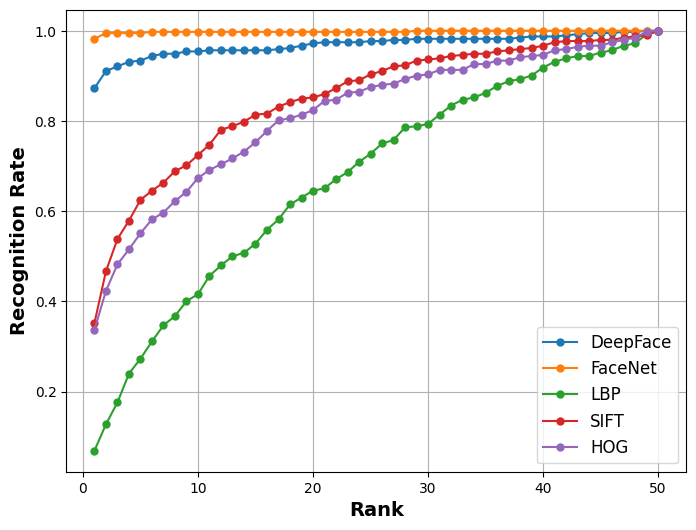

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def parse_features(data):
    """Extract features and labels from the given data dictionary."""
    features = []
    labels = []
    for idx, info in data.items():
        features.append(info['features'])
        labels.append(info['label'])
    return np.array(features), np.array(labels)

def calculate_similarity_matrix(features):
    """Calculate the cosine similarity matrix."""
    # Normalize features
    normalized_features = features / np.linalg.norm(features, axis=1, keepdims=True)
    # Compute pairwise cosine similarity
    similarity_matrix = np.dot(normalized_features, normalized_features.T)
    return similarity_matrix

def create_n_by_c_matrix(similarity_matrix, labels):
    """Transform similarity matrix to n x c matrix."""
    n = similarity_matrix.shape[0]
    unique_classes = np.unique(labels)
    c = len(unique_classes)
    
    # Map identities to column indices
    class_to_indices = {cls: np.where(labels == cls)[0] for cls in unique_classes}
    n_by_c_matrix = np.full((n, c), np.inf)
    
    # Fill the matrix with minimum dissimilarity values (1 - similarity)
    for i in range(n):
        for j, cls in enumerate(unique_classes):
            class_indices = class_to_indices[cls]
            valid_indices = [idx for idx in class_indices if idx != i]
            if valid_indices:
                n_by_c_matrix[i, j] = 1 - np.max(similarity_matrix[i, valid_indices])
    
    return n_by_c_matrix, unique_classes

def compute_ranks_and_cmc(n_by_c_matrix, true_labels, unique_classes):
    """Compute ranks and CMC for the dataset."""
    n, c = n_by_c_matrix.shape
    class_to_index = {cls: idx for idx, cls in enumerate(unique_classes)}
    ranks = np.zeros(n)
    
    for i in range(n):
        sorted_indices = np.argsort(n_by_c_matrix[i])  # Sort classes by similarity (ascending)
        sorted_classes = unique_classes[sorted_indices]
        true_class_index = class_to_index[true_labels[i]]
        ranks[i] = np.where(sorted_classes == true_labels[i])[0][0]  # Rank of the correct class

    cmc = np.zeros(c)
    for z in range(c):
        cmc[z] = np.sum(ranks <= z) / n  # Fraction of queries with rank <= z
    
    return ranks, cmc

def plot_cmc_curve(cmc_dict):
    """Plot the CMC curves for multiple feature types."""
    plt.figure(figsize=(8, 6))
    for feature_type, cmc in cmc_dict.items():
        plt.plot(np.arange(1, len(cmc) + 1), cmc, marker='o', label=feature_type, markersize=5, linewidth=1.5)
    plt.xlabel('Rank', fontsize=14, fontweight='bold')
    plt.ylabel('Recognition Rate', fontsize=14, fontweight='bold')
    plt.grid(True)
    plt.legend(loc='lower right', fontsize=12)
    plt.savefig("pipelineimagecmc.pdf", format='pdf')
    plt.show()

# Process each dataset and compute CMC
datasets = {"DeepFace": test_faces_embeddings_deepface, "FaceNet": test_faces_embeddings_facenet,"LBP": lbp_features, "SIFT": sift_features, "HOG": hog_features}
cmc_results = {}

for feature_type, data in datasets.items():
    features, labels = parse_features(data)
    similarity_matrix = calculate_similarity_matrix(features)
    n_by_c_matrix, unique_classes = create_n_by_c_matrix(similarity_matrix, labels)
    ranks, cmc = compute_ranks_and_cmc(n_by_c_matrix, labels, unique_classes)
    
    # Store CMC curve for plotting
    cmc_results[feature_type] = cmc

    # Print Rank-1 and Rank-5 for this feature type
    rank_1 = np.sum(ranks == 0) / len(ranks)
    rank_5 = np.sum(ranks <= 4) / len(ranks)
    print(f"{feature_type} - Rank-1 Accuracy: {rank_1 * 100:.2f}%")
    print(f"{feature_type} - Rank-5 Accuracy: {rank_5 * 100:.2f}%")

# Plot all CMC curves on one graph
plot_cmc_curve(cmc_results)